<a href="https://colab.research.google.com/github/GFen2/Stocks/blob/main/Stocks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow import keras
import seaborn as sns
import os
from datetime import datetime
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping



In [2]:
!mkdir ~/.kaggle #create the .kaggle folder in your root directory
!echo '{"username": "gfen01","key": "211ea4597d79d6dfb391756234894fc1"}' > ~/.kaggle/kaggle.json #write kaggle API credentials to kaggle.json
!chmod 600 ~/.kaggle/kaggle.json  # set permissions
!pip install kaggle #install the kaggle library

In [3]:
!kaggle datasets list -s {"stocks"}

ref                                                           title                                                size  lastUpdated          downloadCount  voteCount  usabilityRating  
------------------------------------------------------------  --------------------------------------------------  -----  -------------------  -------------  ---------  ---------------  
felsal/ibovespa-stocks                                        ibovespa-stocks                                      25MB  2021-01-01 15:35:39           1711         67  1.0              
iamsouravbanerjee/nifty50-stocks-dataset                      NIFTY-50 Stocks Dataset                               3KB  2022-07-16 17:06:20          10714        316  1.0              
minatverma/nse-stocks-data                                    NSE Stocks Data                                      30MB  2018-01-01 18:26:16           7074        140  0.88235295       
andrewmvd/sp-500-stocks                                       S&P 500 

In [4]:
!kaggle datasets download -d felsal/ibovespa-stocks

 65% 16.0M/24.6M [00:00<00:00, 74.4MB/s]
100% 24.6M/24.6M [00:00<00:00, 92.0MB/s]


In [5]:
! unzip ibovespa-stocks.zip -d train

Archive:  ibovespa-stocks.zip
  inflating: train/b3_stocks_1994_2020.csv  
  inflating: train/selic.csv         
  inflating: train/usd2brl.csv       


In [6]:
data = pd.read_csv('/content/train/b3_stocks_1994_2020.csv')
print(data.shape)
print(data.sample(8))


(1883203, 7)
           datetime ticker    open   close    high     low      volume
175216   1997-07-15  BAZ 3  103.00  105.00  105.00  100.00     22400.0
1283643  2014-04-23  MGLU3    7.10    7.07    7.15    7.00   4412255.0
1258512  2013-12-27  AEDU3   14.45   14.64   14.64   14.32  88563192.0
112018   1996-06-13  EDN 5    8.30    8.30    8.30    8.30        83.0
987319   2010-08-11  TAMM4   28.68   28.49   28.91   27.92  17194624.0
502258   2003-12-04  GEPA4    7.50    7.50    7.50    7.45    160480.0
1499409  2017-01-31  CARD3    7.22    7.30    7.55    7.20   4199682.0
308973   2000-02-22  TCSL3    4.10    4.00    4.15    4.00   1755898.0


In [7]:
data['datetime'] = pd.to_datetime(data['datetime'])
data.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1883203 entries, 0 to 1883202
Data columns (total 7 columns):
 #   Column    Dtype         
---  ------    -----         
 0   datetime  datetime64[ns]
 1   ticker    object        
 2   open      float64       
 3   close     float64       
 4   high      float64       
 5   low       float64       
 6   volume    float64       
dtypes: datetime64[ns](1), float64(5), object(1)
memory usage: 100.6+ MB


In [19]:
""" This could work if I wanted it too
data['datetime'] = pd.to_datetime(data['datetime'])
values = data['ticker']
i=0
# date vs close
plt.figure(figsize=(15, 8))
for index, value in enumerate(values, int(1883203/9)):
  i+=1
  plt.subplot(3, 3, i)
  c = data[data['ticker'] == value]
  plt.plot(c['datetime'], c['close'], c="r", label="close", marker="+")
  plt.plot(c['datetime'], c['open'], c="g", label="open", marker="^")
  plt.title(value)
  plt.legend()
  plt.tight_layout()

"""

'\ndata[\'datetime\'] = pd.to_datetime(data[\'datetime\'])\nvalues = data[\'ticker\']\ni=0\n# date vs close\nplt.figure(figsize=(15, 8))\nfor index, value in enumerate(values, int(1883203/9)):\n  i+=1\n  plt.subplot(3, 3, i)\n  c = data[data[\'ticker\'] == value]\n  plt.plot(c[\'datetime\'], c[\'close\'], c="r", label="close", marker="+")\n  plt.plot(c[\'datetime\'], c[\'open\'], c="g", label="open", marker="^")\n  plt.title(value)\n  plt.legend()\n  plt.tight_layout()\n  \n'

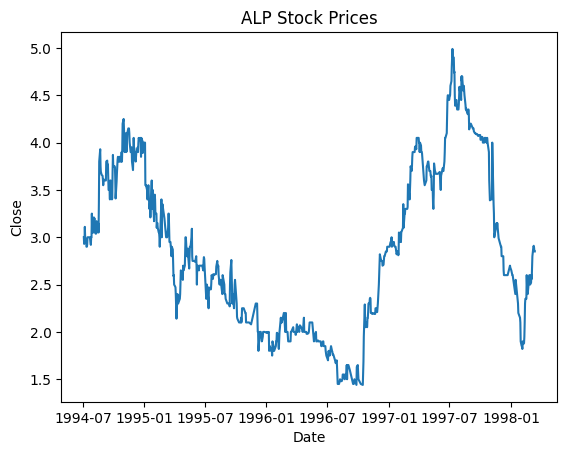

In [9]:
ACE = data[data['ticker'] == 'AVP 3']
prediction_range = ACE.loc[(ACE['datetime'] > datetime(2013,1,1))
 & (ACE['datetime']<datetime(2018,1,1))]
plt.plot(ACE['datetime'],ACE['close'])
plt.xlabel("Date")
plt.ylabel("Close")
plt.title("ALP Stock Prices")
plt.show()


In [10]:
close_data = ACE.filter(['close'])
dataset = close_data.values
training = int(np.ceil(len(dataset) * .90)) #changes interval
print(training)

681


In [11]:
from sklearn.preprocessing import MinMaxScaler
prediction_days=60
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(dataset)

print(scaled_data)
train_data = scaled_data[0:int(training), :]
# prepare feature and labels
x_train = []
y_train = []

for i in range(prediction_days, len(train_data)):
    x_train.append(train_data[i-prediction_days:i, 0])
    y_train.append(train_data[i, 0])

x_train, y_train = np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

[[0.43943662]
 [0.41971831]
 [0.42535211]
 [0.47042254]
 [0.43943662]
 [0.42535211]
 [0.41126761]
 [0.41126761]
 [0.41690141]
 [0.43943662]
 [0.43943662]
 [0.43943662]
 [0.43943662]
 [0.43943662]
 [0.43943662]
 [0.41690141]
 [0.43943662]
 [0.43943662]
 [0.50985915]
 [0.45352113]
 [0.45352113]
 [0.49577465]
 [0.49859155]
 [0.49295775]
 [0.49577465]
 [0.45070423]
 [0.46197183]
 [0.45070423]
 [0.48732394]
 [0.47042254]
 [0.46760563]
 [0.48169014]
 [0.45352113]
 [0.53802817]
 [0.66478873]
 [0.70140845]
 [0.65070423]
 [0.63098592]
 [0.63098592]
 [0.62535211]
 [0.62253521]
 [0.61126761]
 [0.5943662 ]
 [0.6056338 ]
 [0.61126761]
 [0.6084507 ]
 [0.6084507 ]
 [0.66478873]
 [0.66760563]
 [0.63661972]
 [0.65633803]
 [0.62253521]
 [0.58028169]
 [0.58028169]
 [0.55211268]
 [0.6084507 ]
 [0.6084507 ]
 [0.57183099]
 [0.55211268]
 [0.55492958]
 [0.63380282]
 [0.68450704]
 [0.65070423]
 [0.65070423]
 [0.64788732]
 [0.61126761]
 [0.55492958]
 [0.6056338 ]
 [0.63098592]
 [0.67042254]
 [0.67887324]
 [0.66

In [12]:
def LSTM_model():

    model = Sequential()
    model.add(LSTM(units=50, return_sequences=True, input_shape=(x_train.shape[1], 1)))
    model.add(Dropout(0.2))


    model.add(LSTM(units=50, return_sequences=True))
    model.add(Dropout(0.2))


    model.add(LSTM(units=50))
    model.add(Dropout(0.2))

    model.add(Dense(units=1))

    return model

In [13]:
model=LSTM_model()
model.summary()
model.compile(
    optimizer='adam',
    loss='mean_squared_error'
)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 60, 50)            10400     
                                                                 
 dropout (Dropout)           (None, 60, 50)            0         
                                                                 
 lstm_1 (LSTM)               (None, 60, 50)            20200     
                                                                 
 dropout_1 (Dropout)         (None, 60, 50)            0         
                                                                 
 lstm_2 (LSTM)               (None, 50)                20200     
                                                                 
 dropout_2 (Dropout)         (None, 50)                0         
                                                                 
 dense (Dense)               (None, 1)                 5

In [14]:
model.compile(optimizer='adam',
              loss='mean_squared_error')
history = model.fit(x_train,
                    y_train,
                    epochs=10)

Epoch 1/10
20/20 [==============================] - 8s 122ms/step - loss: 0.0549
Epoch 2/10
20/20 [==============================] - 2s 76ms/step - loss: 0.0130
Epoch 3/10
20/20 [==============================] - 1s 73ms/step - loss: 0.0078
Epoch 4/10
20/20 [==============================] - 1s 74ms/step - loss: 0.0070
Epoch 5/10
20/20 [==============================] - 1s 74ms/step - loss: 0.0067
Epoch 6/10
20/20 [==============================] - 1s 73ms/step - loss: 0.0070
Epoch 7/10
20/20 [==============================] - 1s 74ms/step - loss: 0.0063
Epoch 8/10
20/20 [==============================] - 2s 83ms/step - loss: 0.0056
Epoch 9/10
20/20 [==============================] - 2s 119ms/step - loss: 0.0054
Epoch 10/10
20/20 [==============================] - 2s 84ms/step - loss: 0.0061


In [15]:
test_data = scaled_data[training - prediction_days:, :]
x_test = []
y_test = dataset[training:, :]
for i in range(prediction_days, len(test_data)):
	x_test.append(test_data[i-prediction_days:i, 0])

x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))


# predict the testing data
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)

# evaluation metrics
mse = np.mean(((predictions - y_test) ** 2))
print("MSE", mse)
print("RMSE", np.sqrt(mse))


3/3 [==============================] - 1s 20ms/step
MSE 0.14227408804319958
RMSE 0.3771923753778694


<ipython-input-16-f627cc0093bd>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['Predictions'] = predictions


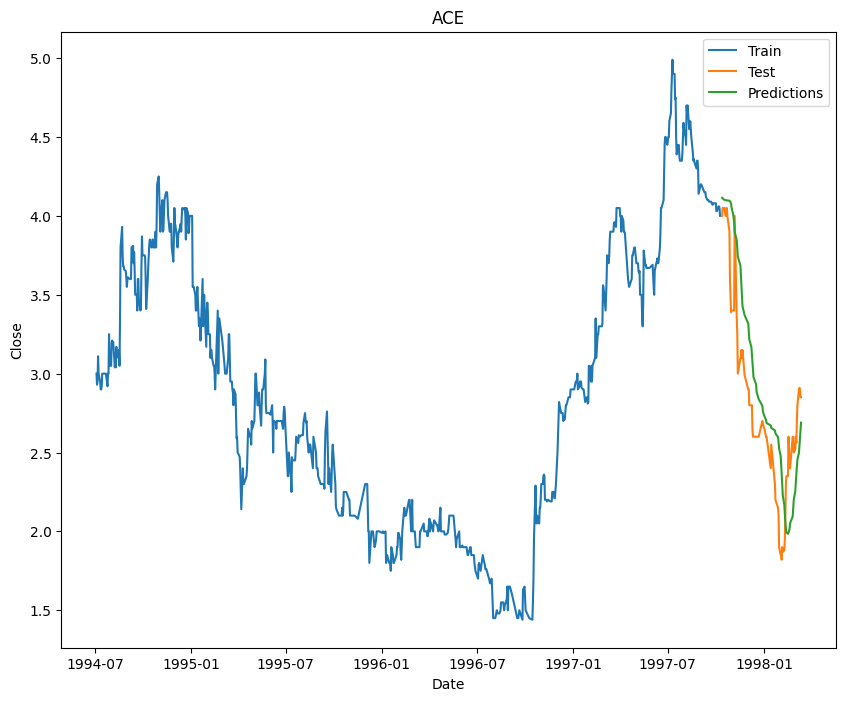

In [16]:
train = ACE[:training]
test = ACE[training:]
test['Predictions'] = predictions



plt.figure(figsize=(10, 8))

plt.plot(train['datetime'], train['close'])
plt.plot(test['datetime'], test[['close', 'Predictions']])
#plt.plot(train['datetime'],train['open'], color='green', label=f"Predicted {'yoot'} price")
plt.title('ACE')
plt.xlabel('Date')
plt.ylabel("Close")
plt.legend(['Train', 'Test', 'Predictions'])

In [17]:
print(test)

         datetime ticker  open  close  high   low   volume  Predictions
189812 1997-10-13  AVP 3  4.00   4.00  4.00  4.00  20800.0     4.114884
190024 1997-10-14  AVP 3  4.00   4.05  4.05  4.00  31943.0     4.111033
190242 1997-10-15  AVP 3  4.04   4.05  4.05  4.04  49792.0     4.107326
190476 1997-10-16  AVP 3  4.05   4.05  4.05  4.04  61942.0     4.104231
190698 1997-10-17  AVP 3  4.05   4.05  4.05  4.05   8910.0     4.101972
...           ...    ...   ...    ...   ...   ...      ...          ...
208367 1998-03-09  AVP 3  2.79   2.90  2.90  2.79  29614.0     2.498595
208581 1998-03-10  AVP 3  3.00   2.91  3.00  2.91  27584.0     2.544847
208804 1998-03-11  AVP 3  2.89   2.89  2.89  2.89   4913.0     2.593058
209027 1998-03-12  AVP 3  2.85   2.85  2.85  2.85   2850.0     2.641995
209249 1998-03-13  AVP 3  2.85   2.85  2.85  2.85   6840.0     2.689435

[75 rows x 8 columns]
